## ** The Improved Power Disaggregation (Non-intrusive Load Monitoring) **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * How feature engineering can affect disaggregation performance is examined
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

#### import packages of benchmark project (contrib. project) to be compared

- https://github.com/OdysseasKr/neural-disaggregator
- The project implemented 5 neural network-based NILM models
  * RNN (Recurrent Neural Network)
  * GRU (Gated Recurrent Unit)
  * Window GRU
  * DAE (Denosing Autoencoder)
  * S2P (Short Sequence to Point)

In [5]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

#### Configuration

In [6]:
###############################################################
# Common
###############################################################
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/enertalk.h5'

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

HOME_ID = 1
appliances = ['television', 'washing machine', 'rice cooker', 'water filter', 'microwave']

In [7]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        
    return predicted

## Alogorithm Comparison with Features

- Description
  It divides the preceding 1 minute into units of 6 seconds each, resulting in 10 consecutive data series in the form of a sliding window. 
  The 6-second interval was experimentally determined. Intervals of less than 6 seconds resulted in overly sensitive predictions and 
  degraded performance while those of more than 6 seconds were unable to capture all of the characteristics of residential appliances. The 
  data in each window consisted of 28 features, 
  * including 10 active power features; 
  * 10 Fourier transformed results that correspond to 10 active powers representing frequency domain characteristics; 
  * and 8 statistical features, namely maximum, minimum, difference between maximum and minimum, mean, standard deviation, 25% quartile, 
    50% quartile, and 75% quartile for the 10 active power features.

********************
[DRF-television]
********************


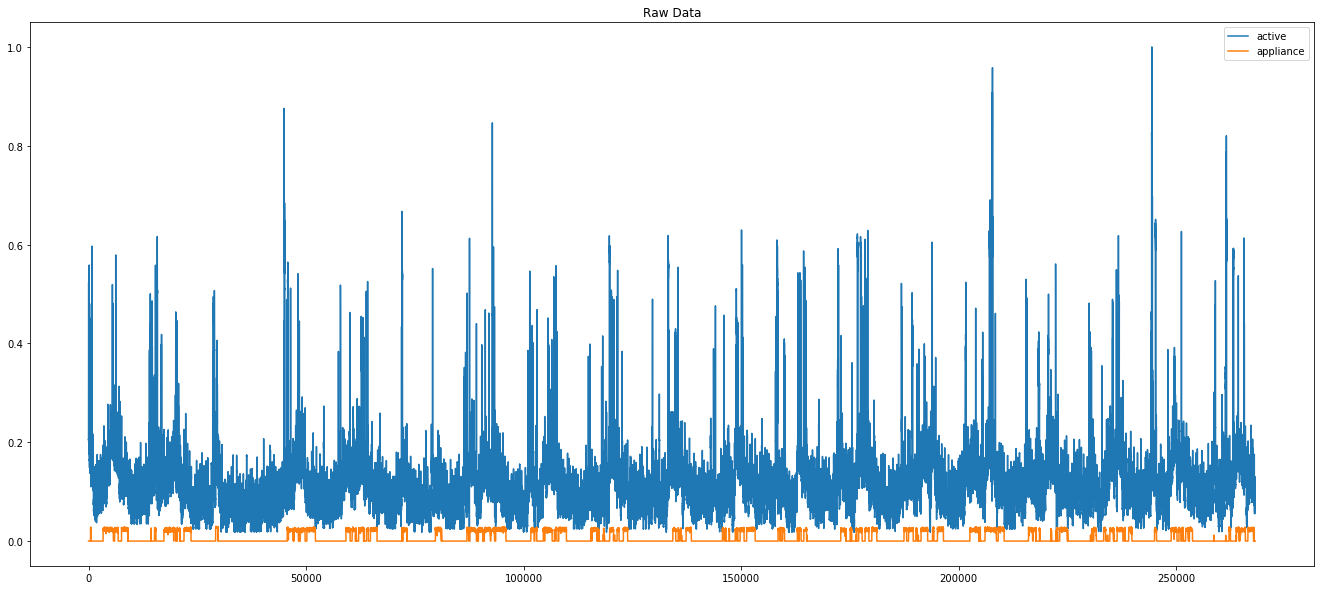

feature selection is done..
model fit is done..
min     0.247586
diff    0.129353
f5      0.060684
std     0.046963
max     0.040628
a9      0.030497
f6      0.028418
f4      0.027956
f7      0.025938
f3      0.025915
a0      0.024181
f2      0.023577
f8      0.023395
q0      0.022658
a1      0.021969
a8      0.021842
f1      0.021724
f9      0.021690
q1      0.020909
q2      0.019081
a2      0.017515
a7      0.017479
a3      0.016657
a6      0.016476
a4      0.016300
a5      0.014581
f0      0.008169
mean    0.007860
dtype: float64


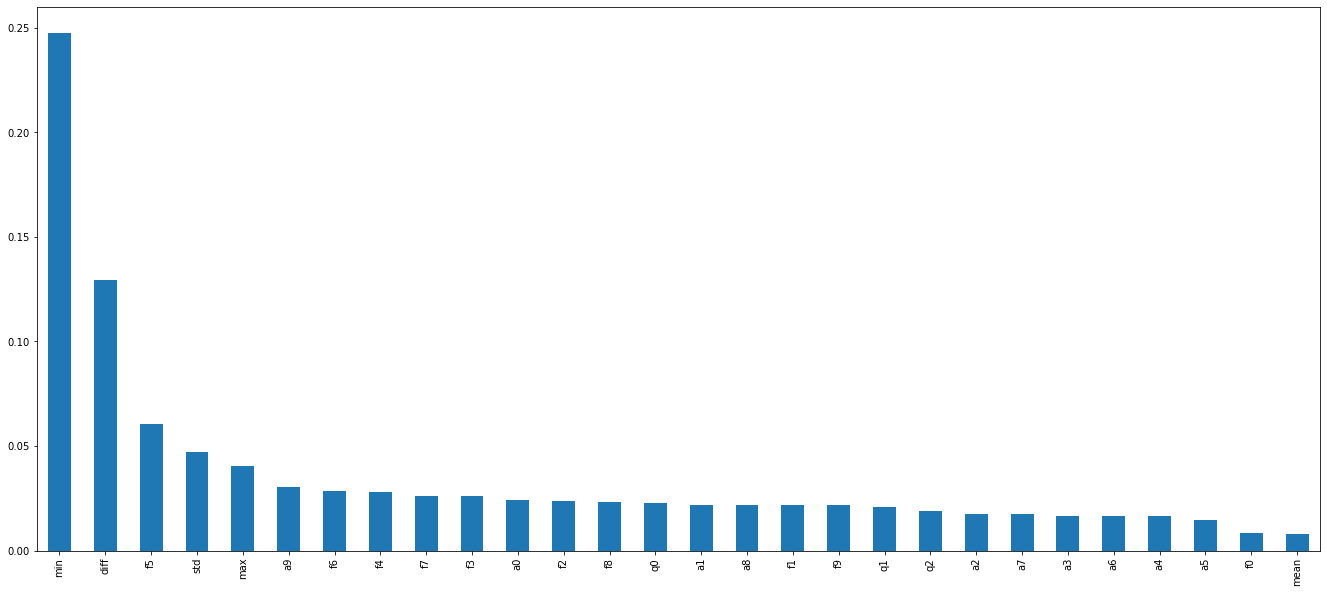

train on chunk is done..
elapsed time (secs) = 1234.959545135498
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.038792146660774275
============ Mean absolute error(in Watts): 27.015454895797337
============ Recall: 0.9531544001557194
============ Precision: 0.45532596342597376
============ Accuracy: 0.618629051870896
============ F1 Score: 0.6162612653554923
********************
[DRF-washing machine]
********************


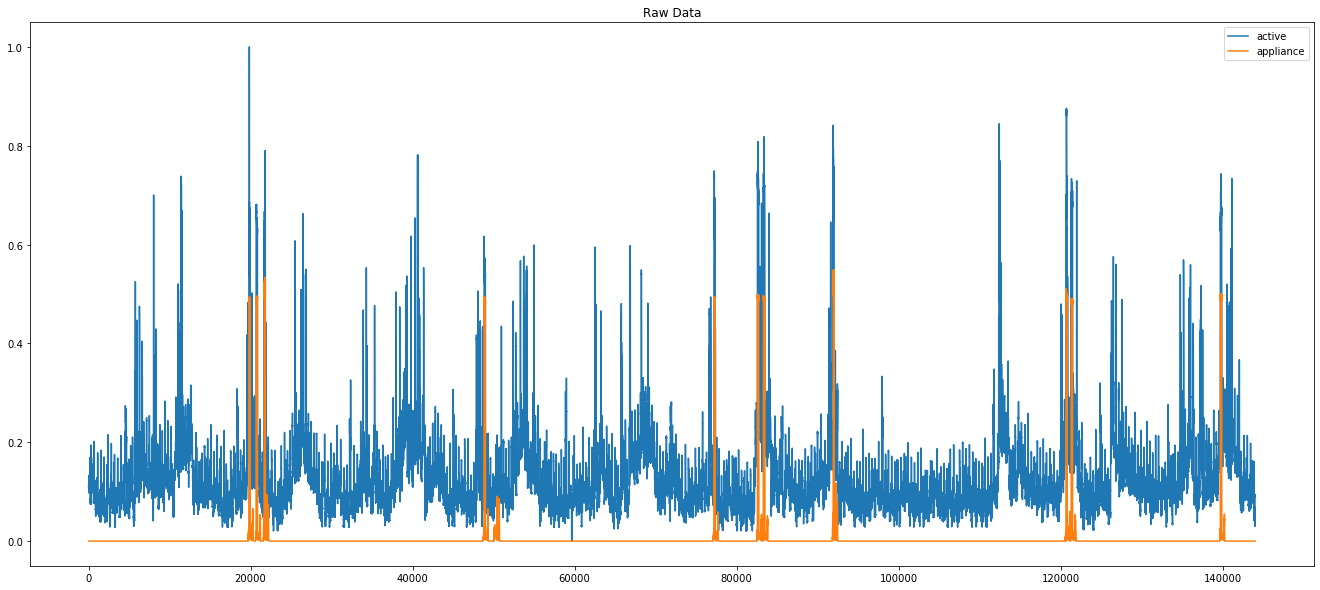

feature selection is done..
model fit is done..
min     0.883784
diff    0.034967
a9      0.023490
std     0.011229
f5      0.005767
max     0.004516
a0      0.004363
q2      0.003919
q0      0.002701
f9      0.002031
f1      0.002005
q1      0.001920
a1      0.001823
f8      0.001687
f4      0.001600
f6      0.001516
f7      0.001506
a8      0.001495
f3      0.001449
f2      0.001424
a7      0.001137
a3      0.001001
a4      0.000993
a2      0.000958
a6      0.000906
a5      0.000709
f0      0.000597
mean    0.000506
dtype: float64


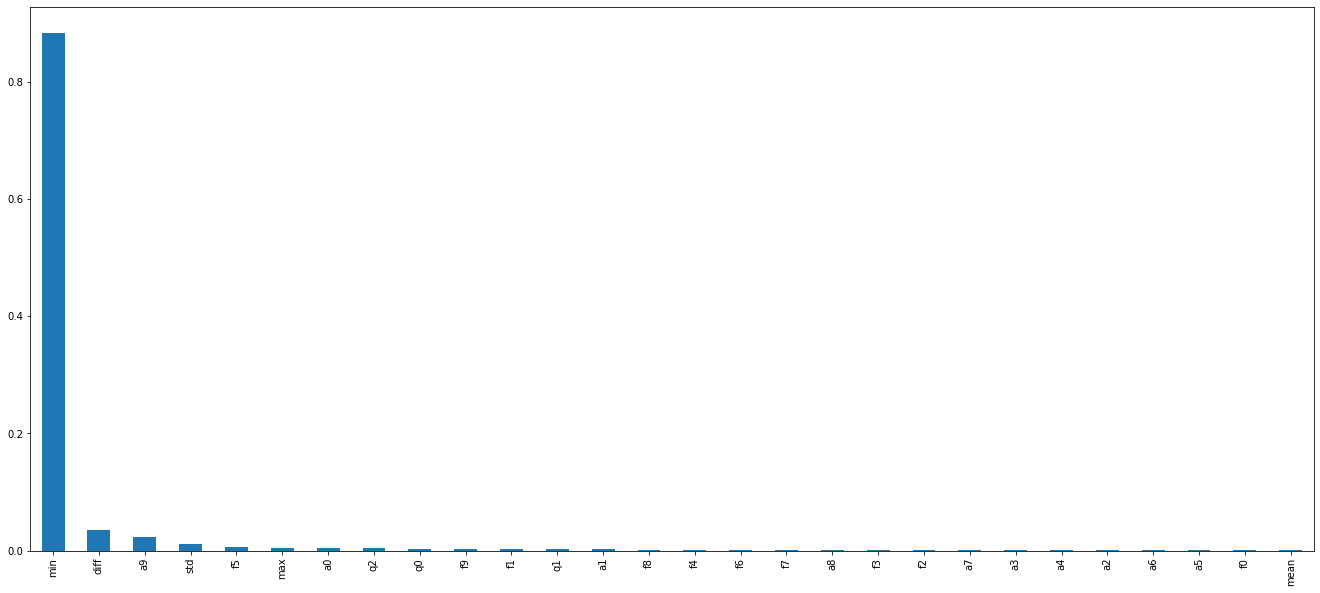

train on chunk is done..
elapsed time (secs) = 1089.3358352184296
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.013305757457240362
============ Mean absolute error(in Watts): 1.9684888130125657
============ Recall: 0.9046992233776491
============ Precision: 0.8324854651162791
============ Accuracy: 0.9853594135427162
============ F1 Score: 0.8670914022582477
********************
[DRF-rice cooker]
********************


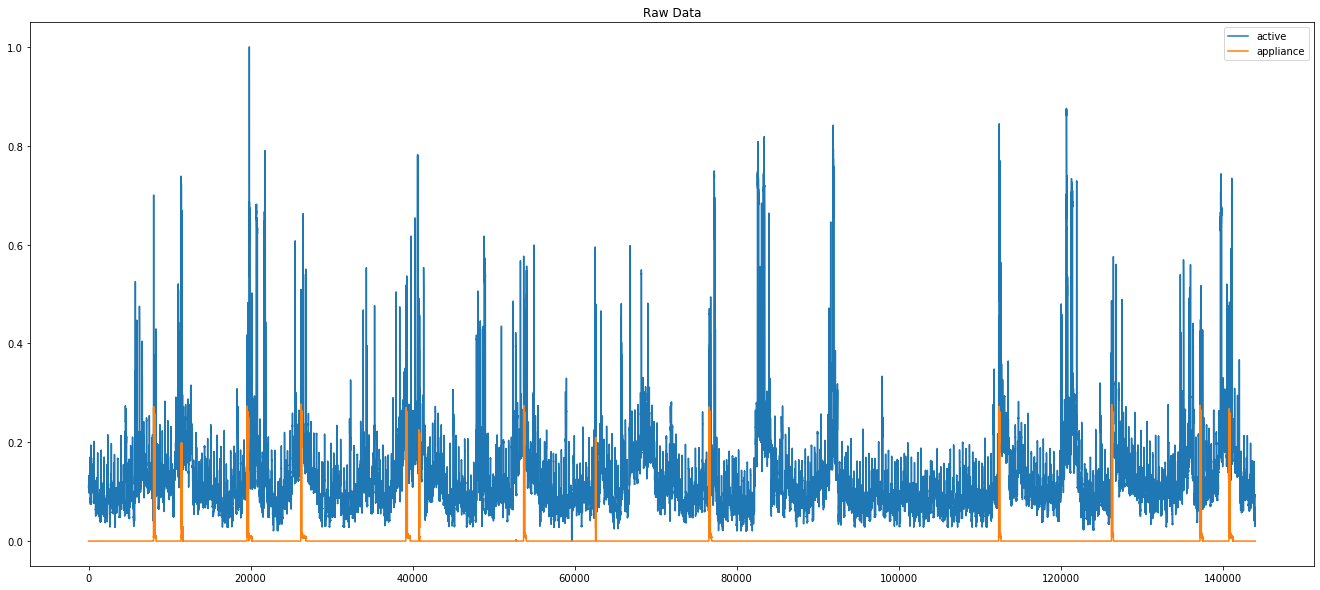

feature selection is done..
model fit is done..
a9      0.482078
max     0.154826
min     0.109680
diff    0.039877
a1      0.031550
std     0.030708
q0      0.012899
q1      0.012442
a8      0.011989
a0      0.010954
q2      0.010752
a4      0.007589
f4      0.007148
f6      0.006981
f5      0.006650
f3      0.006068
a7      0.006021
a6      0.005897
f7      0.005572
a2      0.005522
f1      0.004946
f2      0.004806
f9      0.004702
a5      0.004221
a3      0.004189
mean    0.004139
f0      0.004109
f8      0.003686
dtype: float64


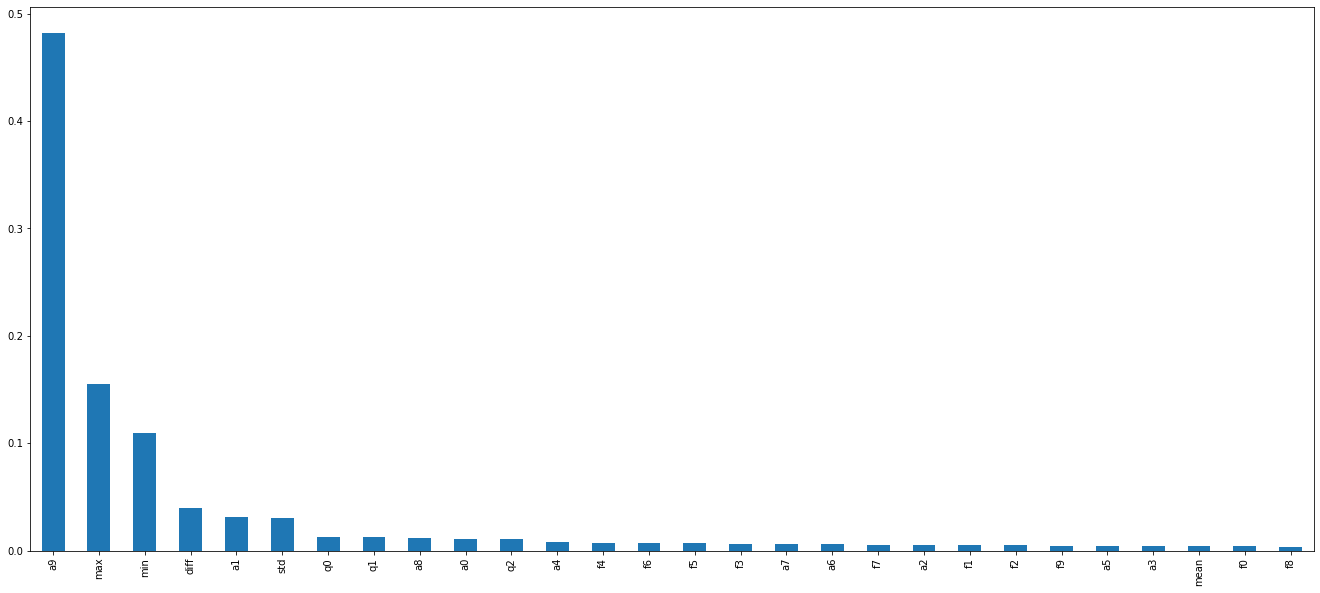

train on chunk is done..
elapsed time (secs) = 972.5333409309387
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.0023847701845396375
============ Mean absolute error(in Watts): 1.3136839509753986
============ Recall: 0.8603384555533943
============ Precision: 0.8392789373814041
============ Accuracy: 0.9891255254837925
============ F1 Score: 0.8496782249543752
********************
[DRF-water filter]
********************


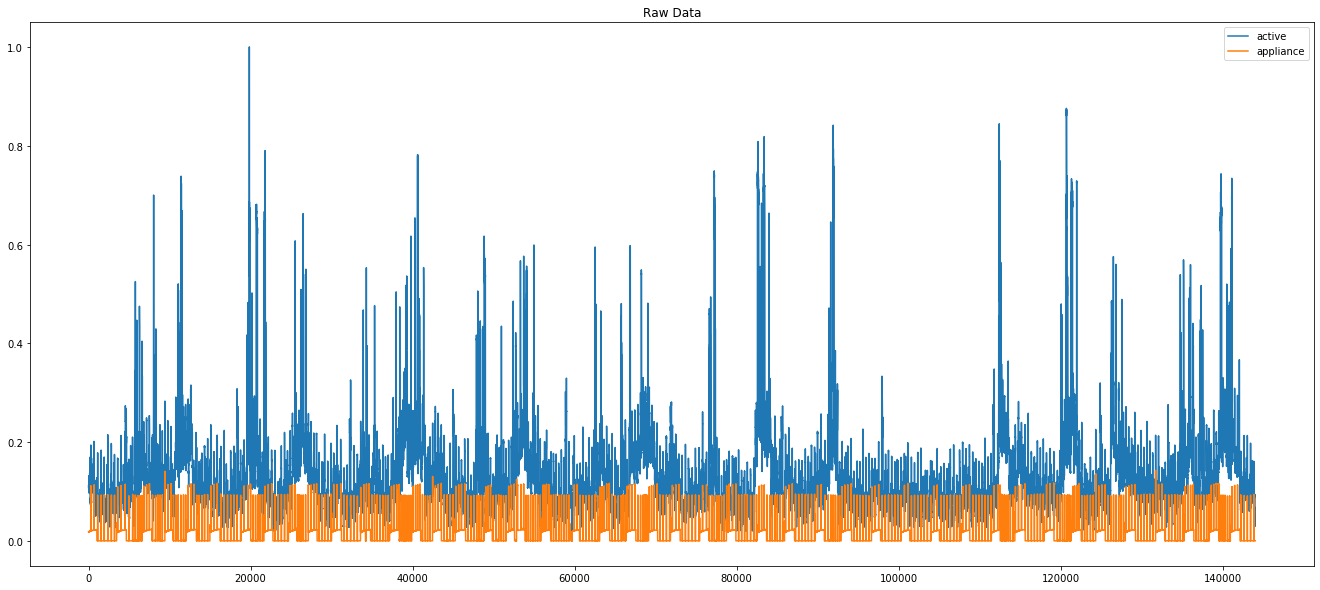

feature selection is done..
model fit is done..
a9      0.232361
diff    0.114053
min     0.105315
max     0.082162
a0      0.080788
std     0.036842
a8      0.027423
q0      0.027142
f5      0.025582
q2      0.023770
q1      0.020194
a1      0.019561
f4      0.016331
a7      0.016317
f6      0.015260
a2      0.014423
f1      0.013550
f9      0.013378
a6      0.012988
a3      0.012960
f2      0.012903
f8      0.012848
f7      0.012345
f3      0.012265
a4      0.012146
a5      0.011871
mean    0.007917
f0      0.007304
dtype: float64


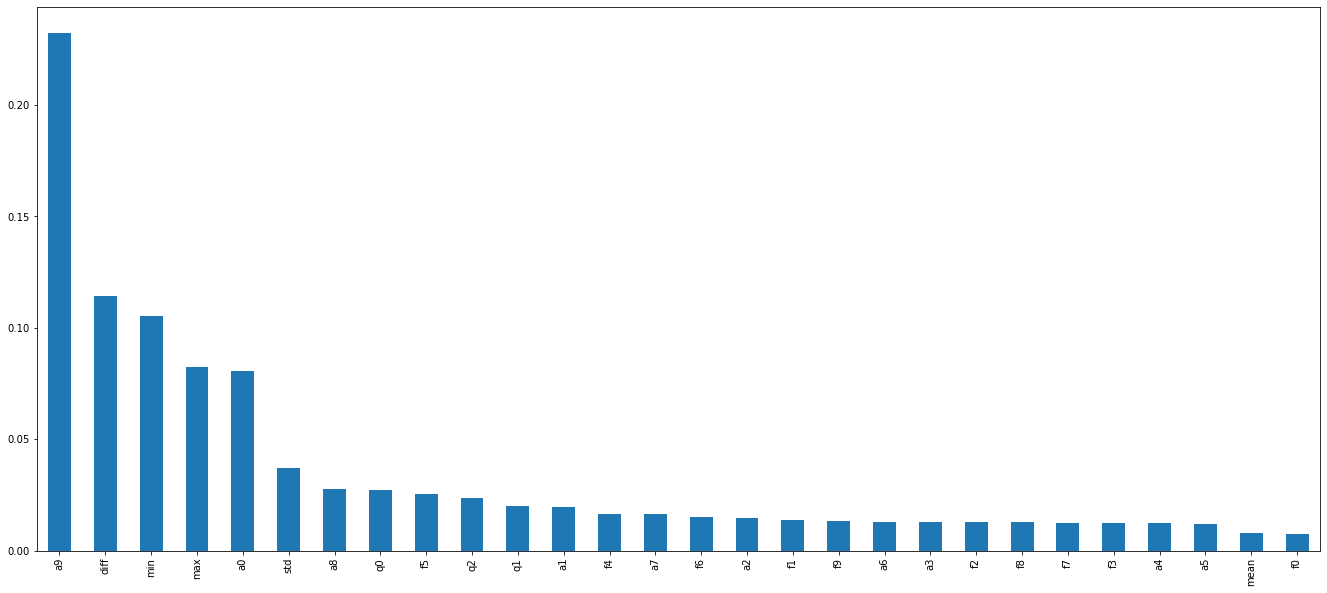

train on chunk is done..
elapsed time (secs) = 603.4680199623108
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.01009474579188002
============ Mean absolute error(in Watts): 11.839637749747098
============ Recall: 0.9946013359984965
============ Precision: 0.6169407825018015
============ Accuracy: 0.7466351665913907
============ F1 Score: 0.7615191926591104
********************
[DRF-microwave]
********************


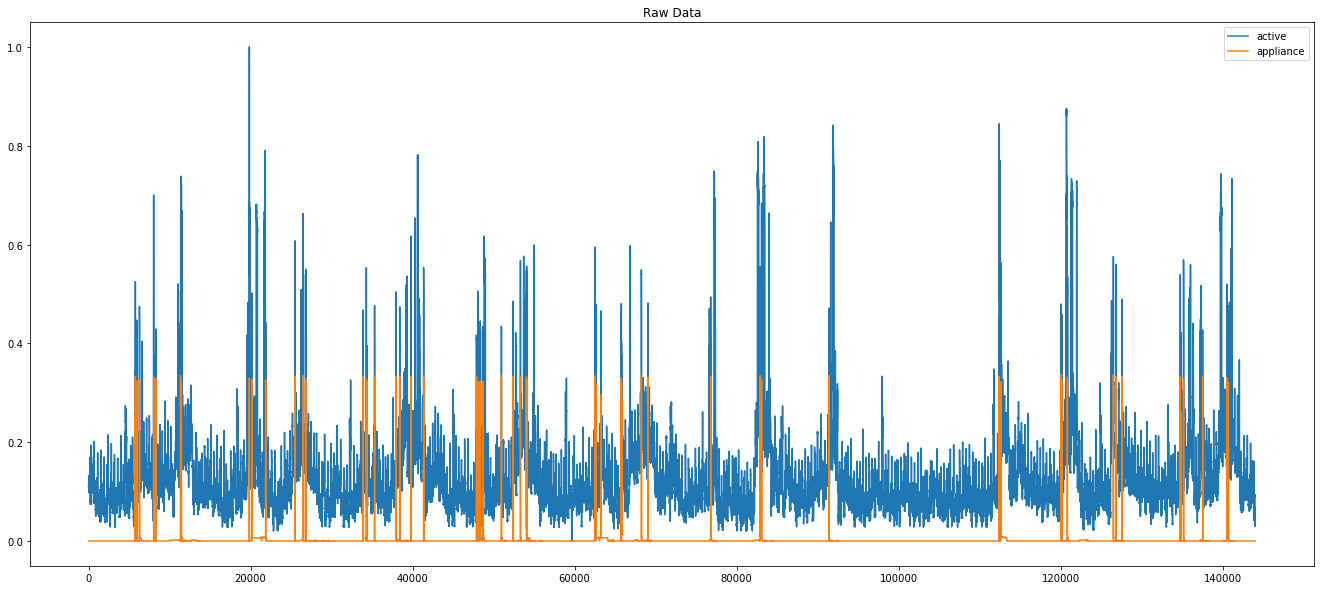

feature selection is done..
model fit is done..
diff    0.358728
a9      0.164686
f4      0.072862
f6      0.055336
std     0.034775
a8      0.030043
f5      0.027122
max     0.024493
min     0.024106
a1      0.023454
f8      0.019091
f2      0.018778
q2      0.014474
q1      0.013070
a6      0.013024
f1      0.011619
a0      0.010922
f9      0.010733
a7      0.010030
f3      0.009746
a2      0.008965
f7      0.008015
q0      0.007795
a4      0.007749
a3      0.006266
a5      0.005823
f0      0.004862
mean    0.003433
dtype: float64


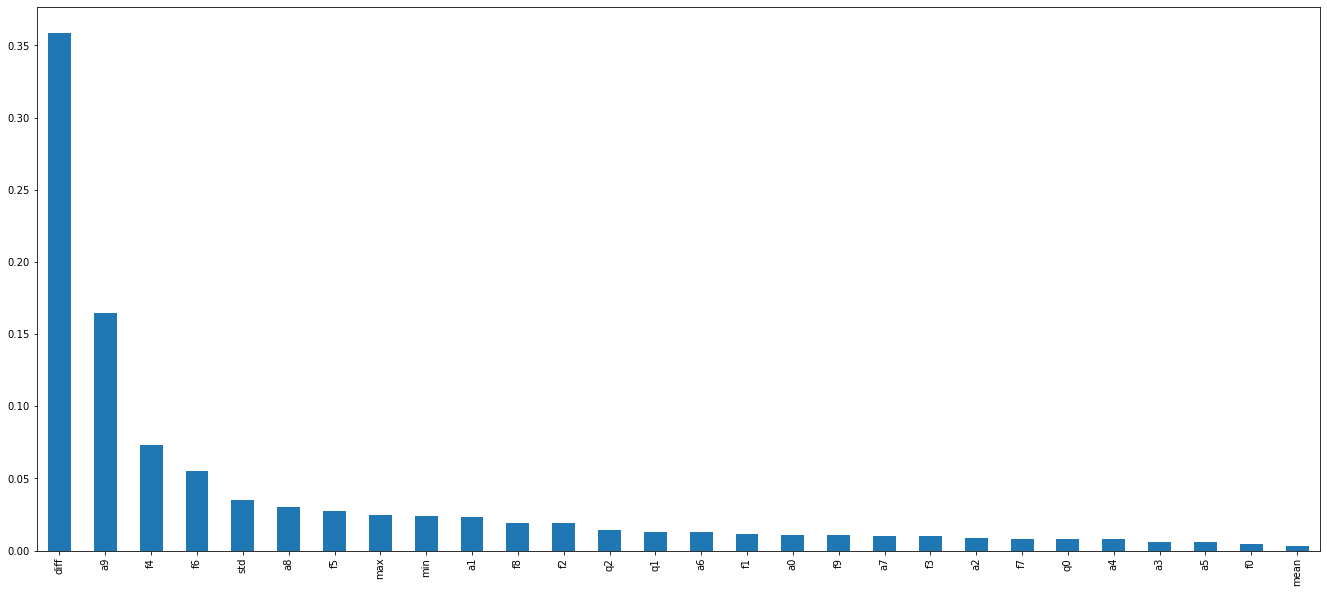

train on chunk is done..
elapsed time (secs) = 929.9982478618622
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.006614022210539228
============ Mean absolute error(in Watts): 1.5406052935366585
============ Recall: 0.9140222727817028
============ Precision: 0.8758462421113024
============ Accuracy: 0.9874926171698573
============ F1 Score: 0.8945271299660144


In [8]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    #models['GRU-' + aname] = GRUDisaggregatorFE()
    #models['RNN-' + aname] = RNNDisaggregatorFE()
    #models['WGRU-' + aname] = WindowGRUDisaggregatorFE(window_size=50)
    #models['DAE-' + aname] = DAEDisaggregatorFE(256)
    #models['S2P-' + aname] = ShortSeq2PointDisaggregatorFE(window_size=100)
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    #models['GBM-' + aname] = DTDisaggregator(algorithm='GBM', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
  

## Alogorithm Comparison with Features + Reactive

- description
  Thirty reactive power and derivative features were added of which 10 were reactive power features, 10 were apparent power features, and 
  10 were power factor features for a total of 58 features.

********************
[DRF-television]
********************
elapsed time (secs) = 65.99928212165833
train & test error 'RandomForestRegressor' object has no attribute 'estimators_'
********************
[DRF-washing machine]
********************


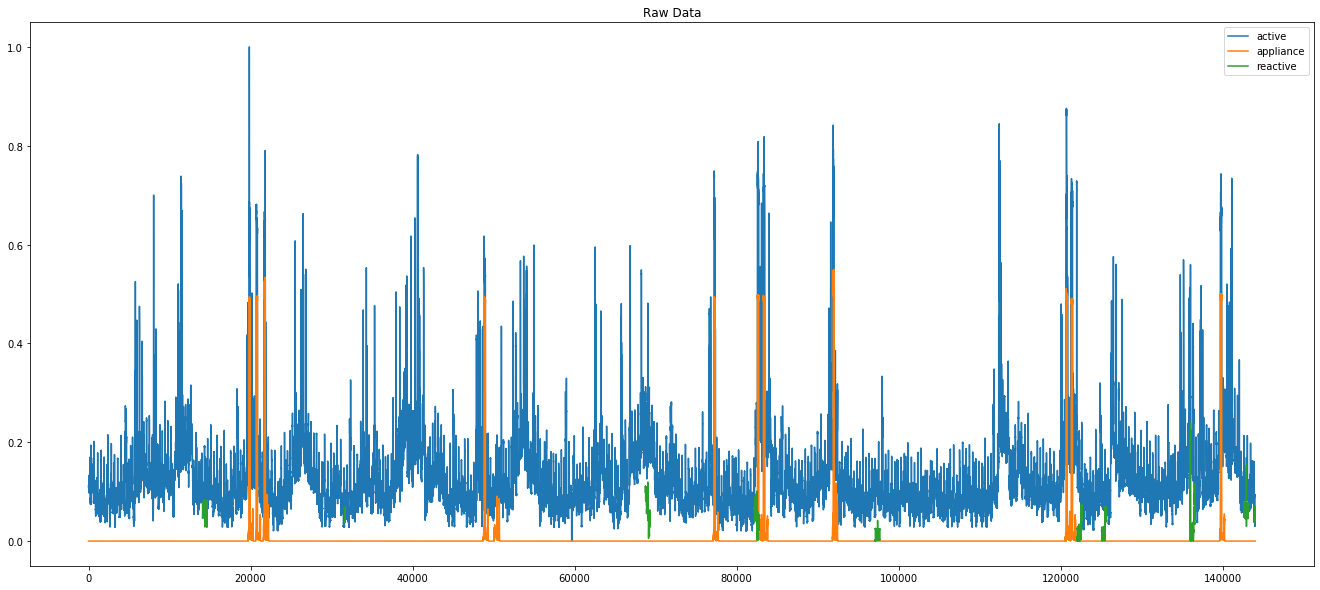

feature selection is done..
model fit is done..
min     8.845420e-01
diff    3.541424e-02
a9      1.370486e-02
std     1.099825e-02
ap9     1.041106e-02
f5      5.245003e-03
max     4.584440e-03
q2      2.780076e-03
a0      2.449622e-03
q0      2.288380e-03
f9      2.035419e-03
ap0     1.997471e-03
f4      1.923352e-03
f1      1.912883e-03
f2      1.733560e-03
f8      1.524788e-03
f6      1.459806e-03
f7      1.459586e-03
f3      1.329952e-03
q1      1.254437e-03
ap1     9.687435e-04
a1      8.136835e-04
a3      7.837487e-04
a8      7.478972e-04
ap8     7.373738e-04
ap7     6.268124e-04
a2      6.102718e-04
a4      5.571833e-04
a6      5.331981e-04
ap6     5.308528e-04
ap5     5.262985e-04
mean    5.258315e-04
ap4     4.962573e-04
f0      4.694558e-04
ap2     4.533115e-04
a7      4.506051e-04
ap3     4.337288e-04
a5      4.316767e-04
pf2     3.532634e-05
r4      2.726034e-05
r9      2.705041e-05
pf1     2.246119e-05
r0      1.556883e-05
pf4     1.550804e-05
r7      1.447628e-05
r2     

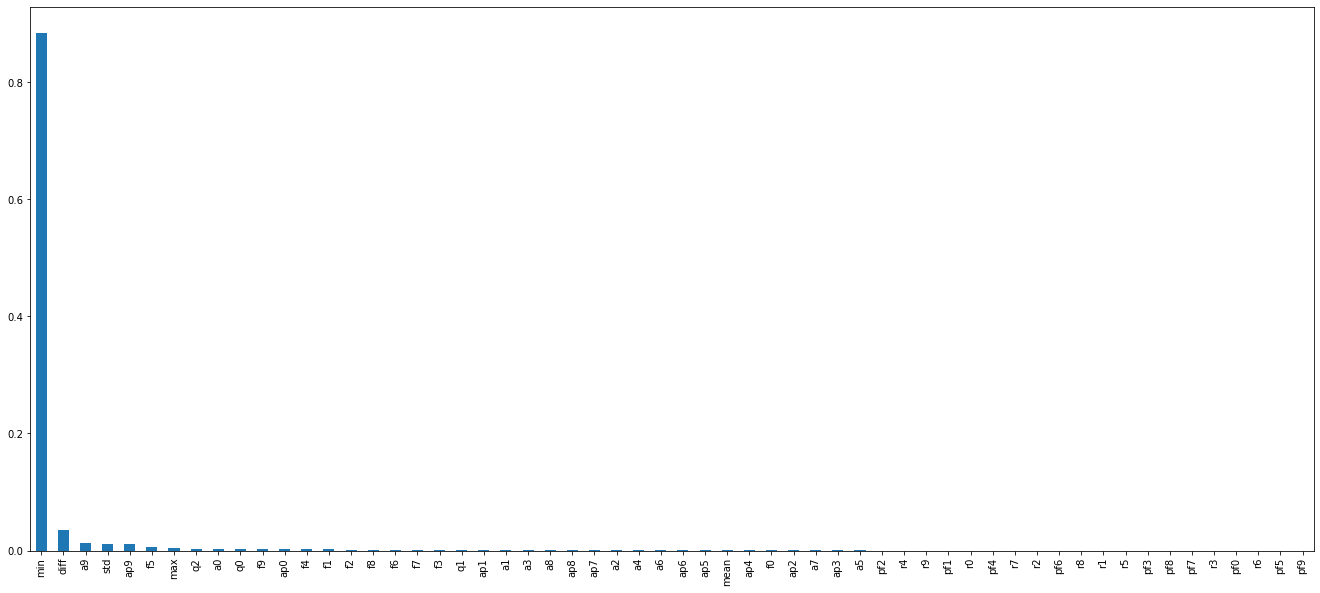

train on chunk is done..
elapsed time (secs) = 1497.899388551712
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.013593002927408311
============ Mean absolute error(in Watts): 1.9847396202856826
============ Recall: 0.9050941160984599
============ Precision: 0.8302342429364887
============ Accuracy: 0.9852204426223813
============ F1 Score: 0.8660494993387492
********************
[DRF-rice cooker]
********************


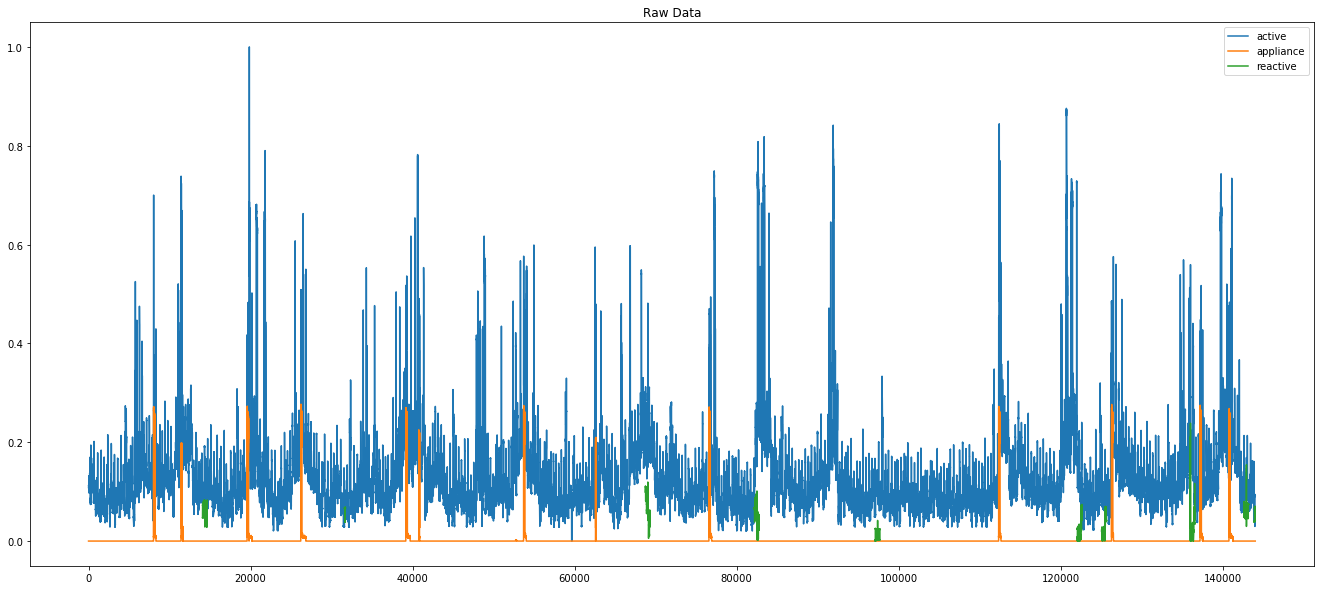

feature selection is done..
model fit is done..
ap9     2.492199e-01
a9      2.335413e-01
max     1.538737e-01
min     9.718794e-02
diff    3.661010e-02
std     2.857279e-02
a1      2.398837e-02
q1      1.330526e-02
pf9     1.254587e-02
ap1     1.226157e-02
q0      9.879882e-03
q2      8.335990e-03
f4      7.074142e-03
ap8     6.931669e-03
f6      6.929959e-03
ap0     6.309666e-03
a0      5.988290e-03
f5      5.896203e-03
f7      4.955811e-03
f3      4.891617e-03
a8      4.767815e-03
f9      4.630454e-03
f8      4.445399e-03
f2      4.386866e-03
f1      4.320529e-03
mean    4.185662e-03
pf8     3.919740e-03
ap2     3.537936e-03
ap4     3.425161e-03
a6      3.417498e-03
a4      3.358713e-03
ap6     3.342572e-03
ap7     3.085919e-03
f0      3.075626e-03
ap3     3.050591e-03
a2      3.038521e-03
a7      2.958516e-03
a5      2.452709e-03
ap5     2.175089e-03
a3      2.107862e-03
pf7     8.485824e-04
pf4     3.231237e-04
pf6     2.044961e-04
pf2     2.006805e-04
pf5     1.534864e-04
pf1    

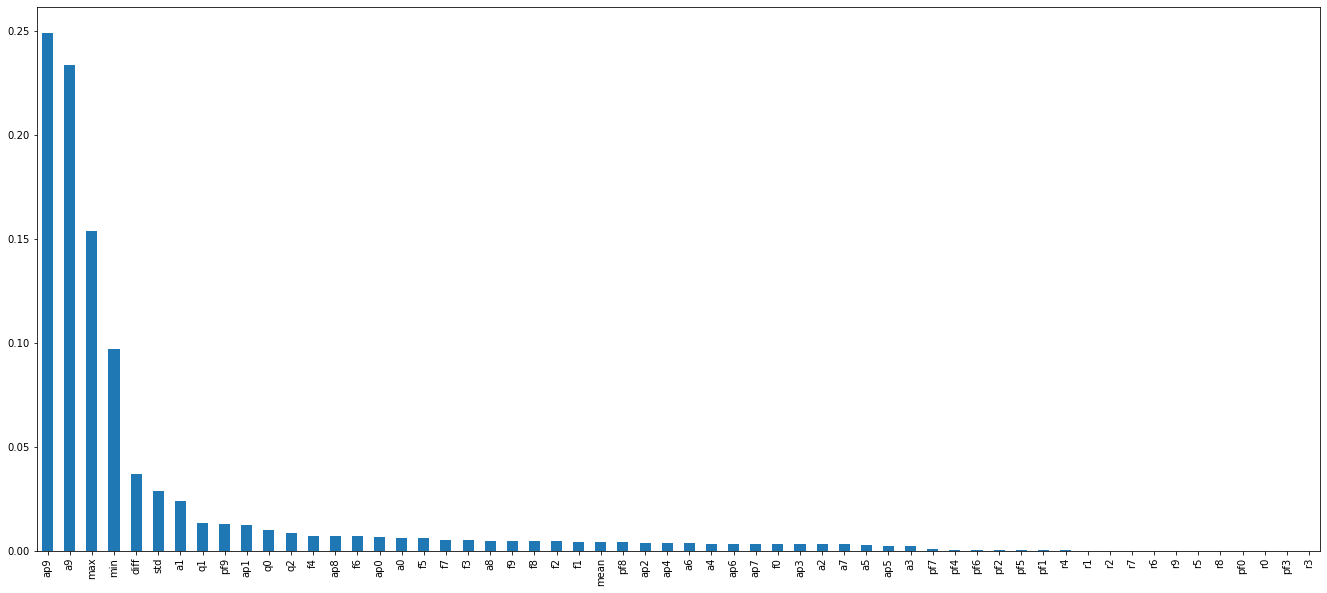

train on chunk is done..
elapsed time (secs) = 1366.5753355026245
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.005942556675094766
============ Mean absolute error(in Watts): 1.283248642607049
============ Recall: 0.8611165142968294
============ Precision: 0.8472727272727273
============ Accuracy: 0.98949379842268
============ F1 Score: 0.854138529808991
********************
[DRF-water filter]
********************


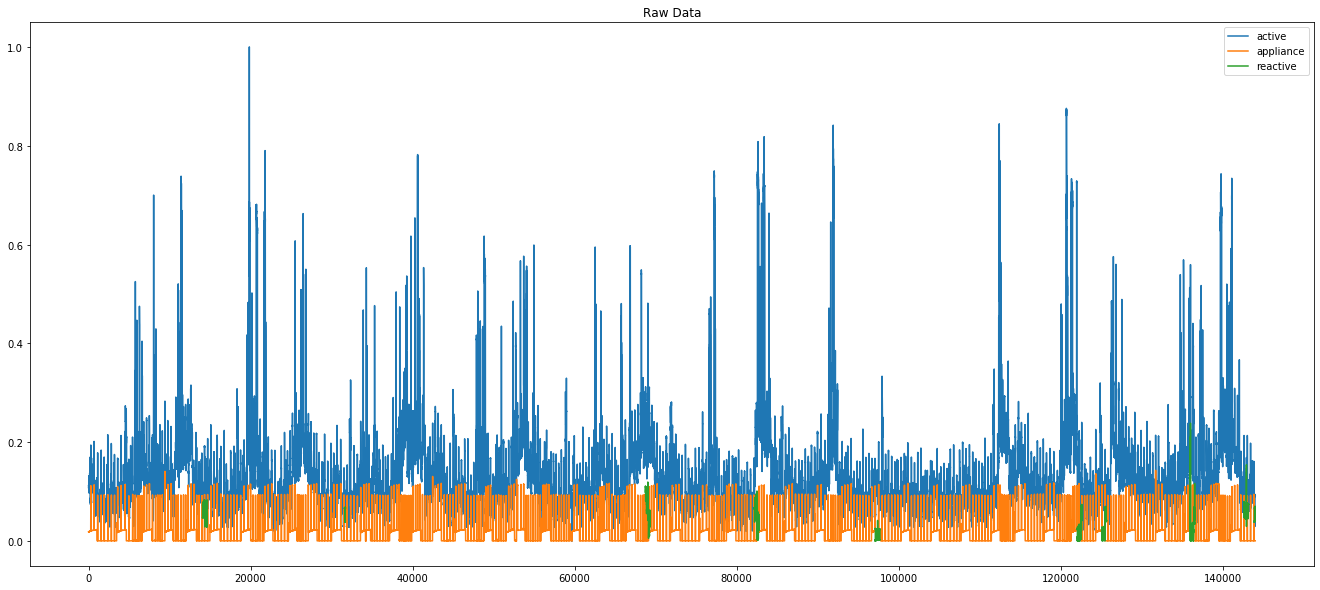

feature selection is done..
model fit is done..
a9      0.207207
diff    0.108598
min     0.103369
max     0.079204
a0      0.050947
std     0.035524
ap0     0.032180
ap9     0.028192
f5      0.023946
q0      0.023584
q2      0.020499
q1      0.018322
ap8     0.017306
f6      0.014163
f4      0.013908
a8      0.013356
f9      0.012213
f1      0.012146
f7      0.011611
f3      0.011606
f2      0.011511
a1      0.011293
f8      0.011198
ap1     0.010765
ap7     0.009016
a7      0.008271
ap6     0.007938
a2      0.007779
ap3     0.007488
ap2     0.007391
ap5     0.007132
ap4     0.007003
a3      0.006984
a6      0.006885
a4      0.006743
mean    0.006672
f0      0.006405
a5      0.006341
r0      0.002105
pf9     0.002052
r9      0.001354
pf0     0.001124
r1      0.001062
pf1     0.000692
r2      0.000671
pf7     0.000568
r8      0.000567
pf8     0.000546
pf4     0.000494
pf3     0.000483
pf6     0.000479
pf2     0.000474
r3      0.000473
pf5     0.000456
r7      0.000455
r4      0.000446


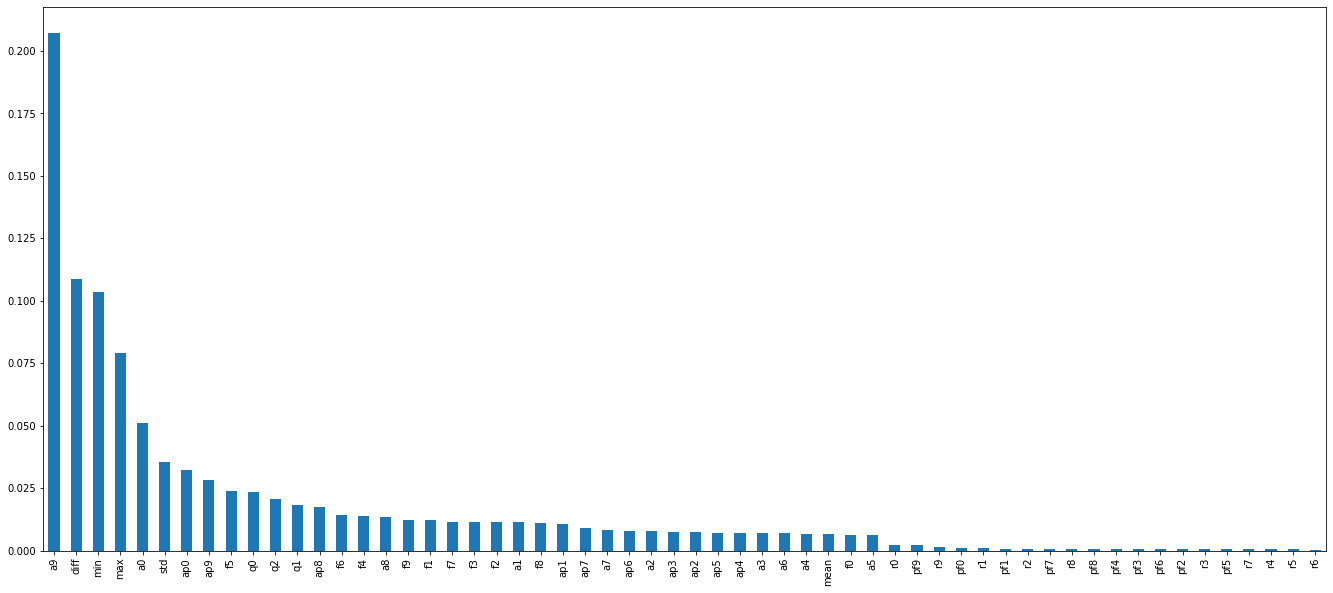

train on chunk is done..
elapsed time (secs) = 861.8885838985443
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.00955878880838573
============ Mean absolute error(in Watts): 11.489135544533289
============ Recall: 0.9944646609604838
============ Precision: 0.6240645839140596
============ Accuracy: 0.7540979050133759
============ F1 Score: 0.7668816325992873
********************
[DRF-microwave]
********************


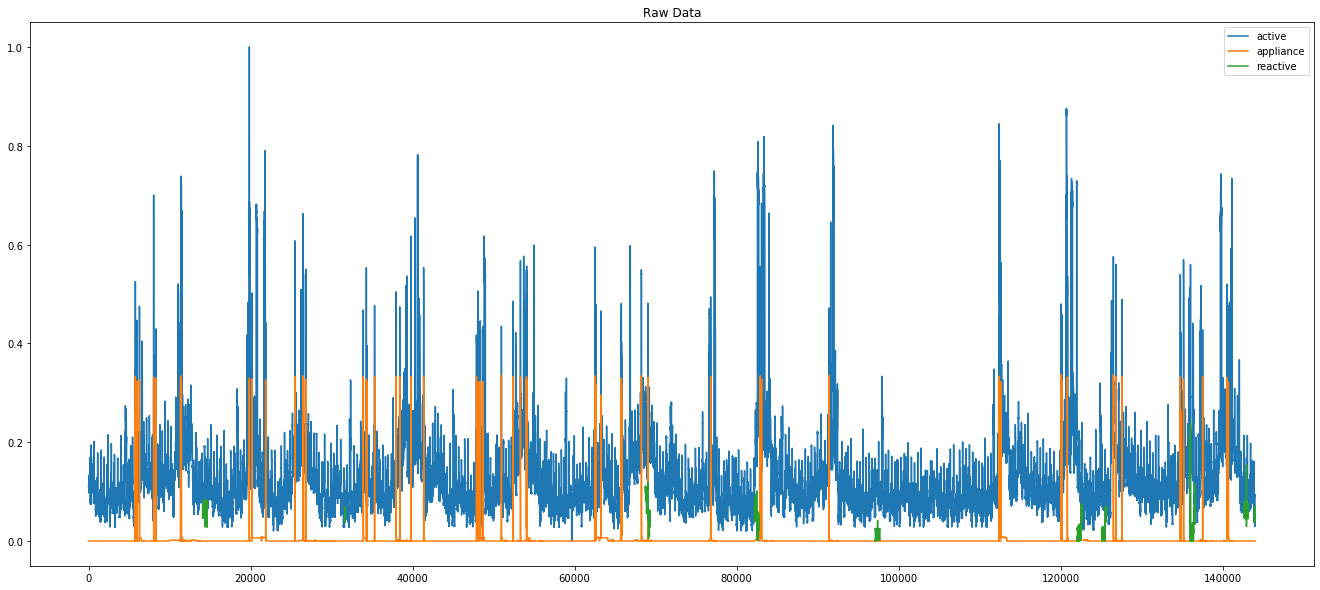

feature selection is done..
model fit is done..
diff    0.376679
a9      0.094183
ap9     0.092769
f4      0.055919
f6      0.039145
std     0.033338
f5      0.026955
min     0.021262
max     0.019668
f8      0.019084
f2      0.018944
q1      0.015649
a1      0.014339
a8      0.013384
q2      0.011746
ap8     0.011655
ap1     0.011321
f9      0.010487
f1      0.010414
q0      0.009642
f3      0.009296
f7      0.009275
ap0     0.008180
ap6     0.007355
a0      0.006398
a6      0.005328
a7      0.004592
ap7     0.004403
ap2     0.004387
mean    0.003927
ap4     0.003859
a2      0.003588
a4      0.003320
a5      0.003202
ap5     0.003147
ap3     0.003075
a3      0.002587
f0      0.002585
pf9     0.001220
r6      0.000655
r4      0.000574
r8      0.000466
r7      0.000424
r5      0.000422
r9      0.000358
pf8     0.000338
pf7     0.000092
r3      0.000091
r0      0.000059
pf6     0.000058
r2      0.000049
pf4     0.000043
pf5     0.000027
pf1     0.000019
pf3     0.000007
r1      0.000005


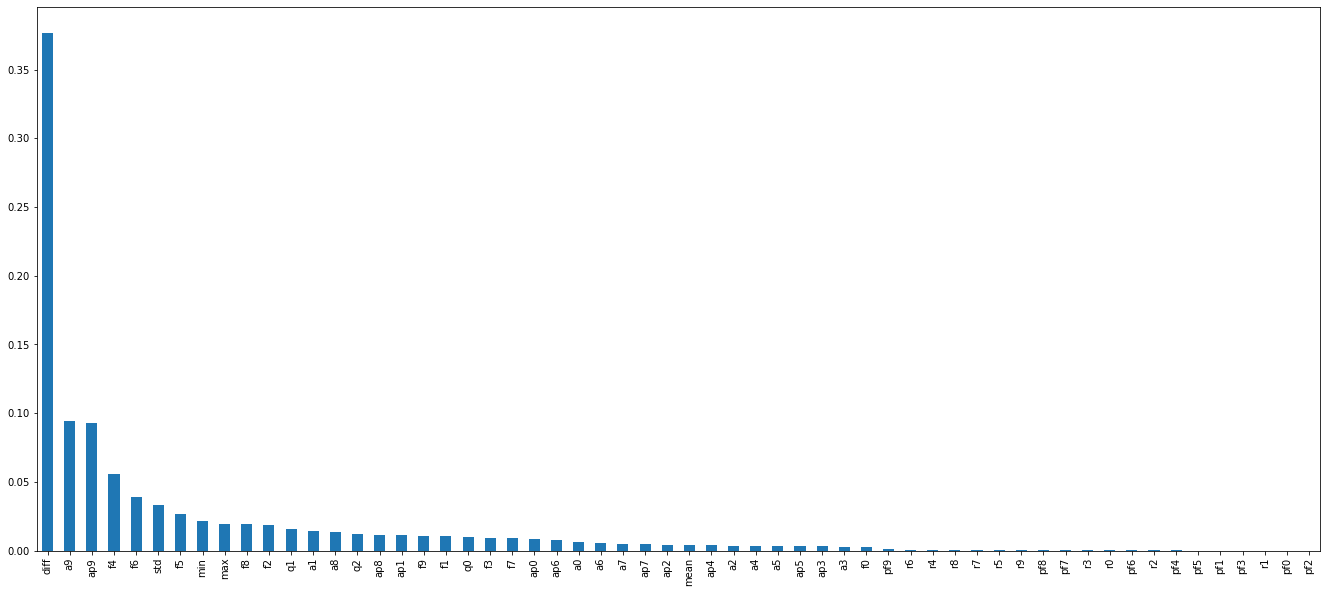

train on chunk is done..
elapsed time (secs) = 1302.2263579368591
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.008499981903461587
============ Mean absolute error(in Watts): 1.5201606702604482
============ Recall: 0.9137827805053287
============ Precision: 0.8730122411623384
============ Accuracy: 0.9872841607893549
============ F1 Score: 0.8929323660191902


In [9]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=True)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
  